# MAP 568 Project

Maxime Vincent & Swann Chelly

In [4]:
import numpy as np

from constant import *
from scipy import *
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [2]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    #temps = round(temps,1)
    #if temps == 50:
    #    temps = 50.1
    #elif temps > 100.:
    #    temps = 100.
    #i = time.index(temps)
    tau = cst['tau_0']*np.exp(-cst['mu']*max(temps-(cst['N']-cst['t_0']),0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_moins
    DI_plus = cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_plus
    DR_moins = cst['gamma_IR']*I_moins-cst['lambda_2']*R_moins
    DR_plus_I = cst['gamma_IR']*I_plus+cst['lambda_2']*R_moins
    DH = cst['gamma_IH']*(I_moins + I_plus)-(cst['gamma_HR']+cst['gamma_HD']+cst['gamma_HU'])*H
    DU = cst['gamma_IU']*(I_moins + I_plus)+cst['gamma_HU']*H-(cst['gamma_UR'] + cst['gamma_UD'])*U
    DR_plus_H = cst['gamma_HR']*H+cst['gamma_UR']*U
    DD = cst['gamma_UD']*U+cst['gamma_HD']*H  
    DD_R = (cst['lambda_1']+cst['gamma_IH']+cst['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


Text(0, 0.5, 'Nombre de personne en réanimation')

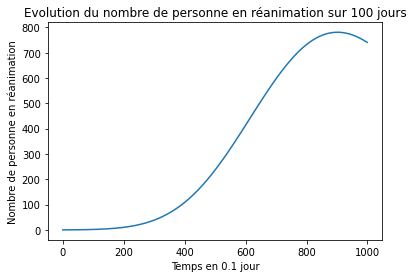

In [59]:
# Analyse des résultats

cst = init_constant()
syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,t)
plt.plot(simulation[:,6])
plt.title(f"Evolution du nombre de personne en réanimation sur {T_MAX} jours")
plt.xlabel(f"Temps en {deltaT} jour")
plt.ylabel("Nombre de personne en réanimation")




2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [84]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 

M = 10000

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur 10000 simulation")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        cst = init_constant()
        syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0]) 
        simulation=odeint(equa_diff,syst_CI,t)           
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*deltaT))
        pos.append(np.max(simulation[:,1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)


Echantillonnage de Monte Carlo sur 10000 simulation


100% |########################################################################|


La valeur moyenne du pic est de 1532.01 et appartient à l'intervalle de confiance à 95% suivant : [1300.75,1763.27] 
 Le quantile à 10% du pic de réanimation est : 0.34180210365684405
 Le quantile à 90% du pic de réanimation est : 586.3361649443412


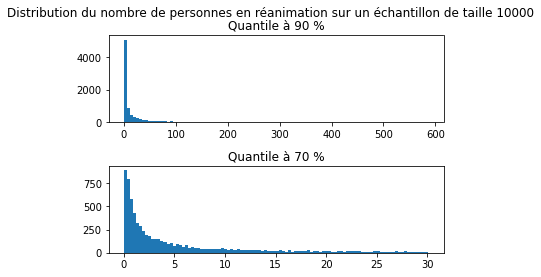

In [88]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if value < q_70], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


0.000652738511655159


(array([1476.91498121, 1358.95052584, 1130.88591213, 1130.88591213,
         940.56992414,  871.36411032,  888.66556377,  732.95248269,
         619.70660553,  605.55087089,  556.79222934,  533.19933826,
         426.24489873,  405.79772647,  386.92341361,  357.03908491,
         311.42616217,  317.71759979,  275.25039586,  235.92891074,
         196.60742561,  212.33601966,  155.71308109,  138.41162763,
         133.69304942,  110.10015834,  117.96445537,  105.38158013,
          92.79870489,   84.93440787,   77.07011084,   66.06009501,
          55.05007917,   69.20581382,   59.76865739,   45.61292274,
          39.32148512,   37.74862572,   34.60290691,   45.61292274,
          34.60290691,   20.44717226,   14.15573464,   25.16575048,
          22.02003167,   17.30145345,   14.15573464,    6.29143762,
          14.15573464,    9.43715643,    9.43715643,    7.86429702,
           7.86429702,    4.71857821,    7.86429702,    7.86429702,
           9.43715643,    6.29143762,    4.71857

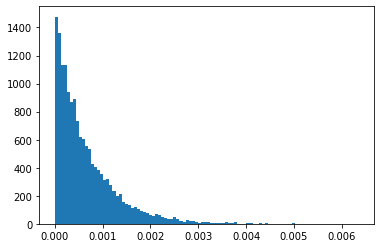

In [98]:
lbd = 1/mean_value
print(lbd)
Y = np.random.exponential(lbd,10000)
plt.hist(Y,bins = 100,density = True)

La valeur moyenne du pic est de 46.61 et appartient à l'intervalle de confiance à 95% suivant : [46.18,47.04] 
 Le quantile à 10% du pic de réanimation est : 23.0
 Le quantile à 90% du pic de réanimation est : 83.0


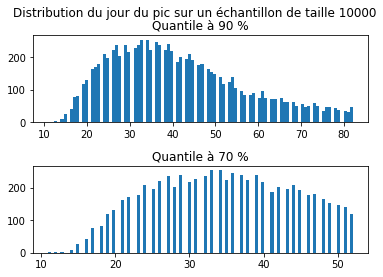

In [86]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if day < q_70_day], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)